In [103]:
from pathlib import Path # to interact with file system.

import numpy as np # for working with arrays.
import pandas as pd # for working with data frames (tables).
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, pairwise
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from dmba import plotDecisionTree, classificationSummary
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from dmba import classificationSummary, gainsChart, liftChart
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import seaborn as sns
from pandas.plotting import parallel_coordinates

%matplotlib inline 
import matplotlib.pylab as plt

## Question 1: Visualization of Sales data (which is Data Order Only sheet of the excel)

In [104]:
sales_df = pd.read_excel('IMB881-XLS-ENG.xlsx', sheet_name='Data Order ONLY')

In [105]:
sales_df.shape

(13135, 12)

In [106]:
sales_df.columns

Index(['CustomerCode', 'CountryName', 'QtyRequired', 'TotalArea', 'Amount',
       'ITEM_NAME', 'QualityName', 'DesignName', 'ColorName', 'ShapeName',
       'AreaFt', 'AreaMtr'],
      dtype='object')

In [107]:
sales_df.head()

,CustomerCode,CountryName,QtyRequired,TotalArea,Amount,ITEM_NAME,QualityName,DesignName,ColorName,ShapeName,AreaFt,AreaMtr
0,H-1,USA,6,128.25,769.5,HAND TUFTED,TUFTED 30C HARD TWIST,OLD LONDON [3715],GREEN/IVORY,REC,128.25,11.543
1,H-1,USA,6,117.00,702.0,HAND TUFTED,TUFTED 60C,DUDLEY [9012],BEIGE,REC,117.00,10.530
2,H-1,USA,7,88.00,616.0,HAND TUFTED,TUFTED 60C,WEMBLY [CC-206],BEIGE/SAGE,REC,88.00,7.920
3,H-1,USA,7,88.00,616.0,HAND TUFTED,TUFTED 60C,SYMPHONY [8900],CHARCOAL,REC,88.00,7.920
4,H-1,USA,5,117.00,585.0,HAND TUFTED,TUFTED 60C,DUDLEY [9012],NAVY/BEIGE,REC,117.00,10.530


In [108]:
sales_df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13135 entries, 0 to 13134
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CustomerCode  13135 non-null  object 
 1   CountryName   13135 non-null  object 
 2   QtyRequired   13135 non-null  int64  
 3   TotalArea     13135 non-null  float64
 4   Amount        13135 non-null  float64
 5   ITEM_NAME     13135 non-null  object 
 6   QualityName   13135 non-null  object 
 7   DesignName    13135 non-null  object 
 8   ColorName     13135 non-null  object 
 9   ShapeName     13135 non-null  object 
 10  AreaFt        13135 non-null  float64
 11  AreaMtr       13135 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.2+ MB


No misssing values in the data

In [109]:
sales_df.describe()

,QtyRequired,TotalArea,Amount,AreaFt,AreaMtr
count,13135.000,13135.000,13135.000,13135.000,13135.000
mean,44.461,44.731,2392.040,54.622,4.952
std,228.750,50.100,16832.091,49.073,4.456
min,1.000,0.040,0.000,0.444,0.040
25%,3.000,5.800,163.200,15.000,1.350
50%,8.000,24.000,590.625,40.000,3.600
75%,20.000,80.000,1540.000,80.000,7.200
max,6400.000,1024.000,599719.680,645.722,60.000


In [110]:
sales_df.dtypes

CustomerCode     object
CountryName      object
QtyRequired       int64
TotalArea       float64
Amount          float64
ITEM_NAME        object
QualityName      object
DesignName       object
ColorName        object
ShapeName        object
AreaFt          float64
AreaMtr         float64
dtype: object

## Exploration of the sales data

In [111]:
num_col = ['QtyRequired', 'TotalArea', 'Amount']
cat_col = ['CustomerCode','CountryName','ITEM_NAME', 'QualityName', 'DesignName', 'ColorName', 'ShapeName']

## Observation 1: AreaFt and AreaMt are redundant columns, we already have TotalArea column which is the area of the carpet in mts, so we are not taking them in our numerical colums list

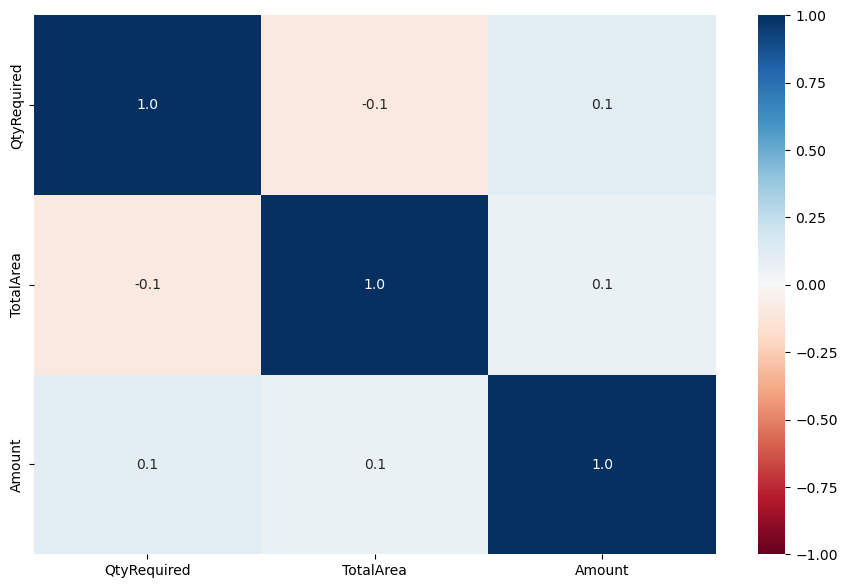

In [112]:
#show the heatmap for the dataframe
corr = sales_df[num_col].corr()
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=True, fmt=".1f", cmap="RdBu", center=0, ax=ax, vmin=-1, vmax=1,)

plt.show()

## Obs 2: There is not much of the co-relation between numerical columns with each other

## Making a Count plot of categorical columns with a few categories to see which has the most count, then Champo can target that category

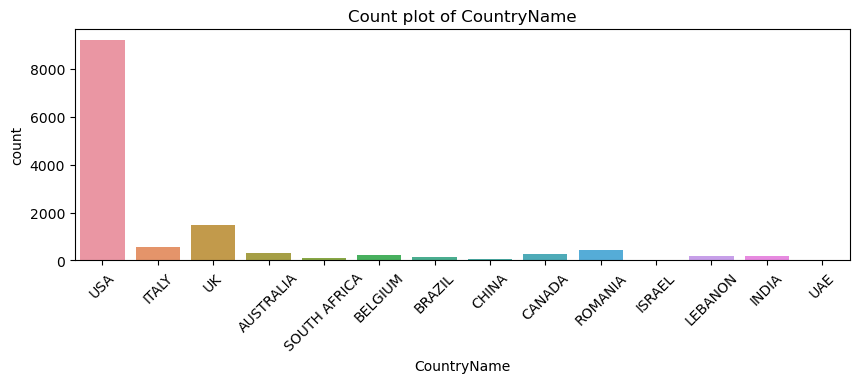

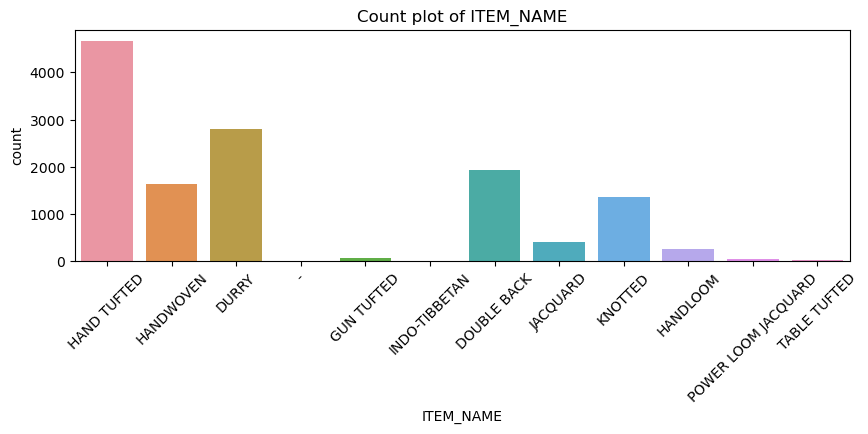

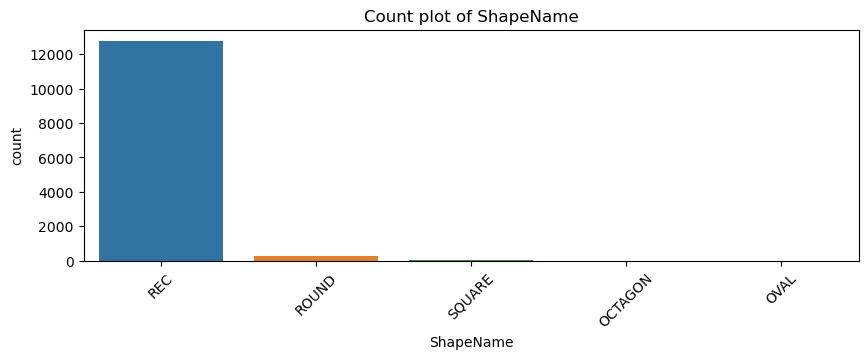

In [19]:
# Count plot for categorical columns
categorical_columns = ['CountryName', 'ITEM_NAME', 'ShapeName']
for col in categorical_columns:
    plt.figure(figsize=(10, 3))
    sns.countplot(x=col, data=sales_df)
    plt.title(f'Count plot of {col}')
    plt.xticks(rotation=45)
    plt.show()


## from these charts we can say that USA is giving the order most frequently (cant say if the highest amount or not yet), and Hand Tufted item is the most frequently selling item, Also, apparactly rectangular shape is quite popular

## Now, seeing which Item_name and Country is giving the maximum sales (sum of amount)

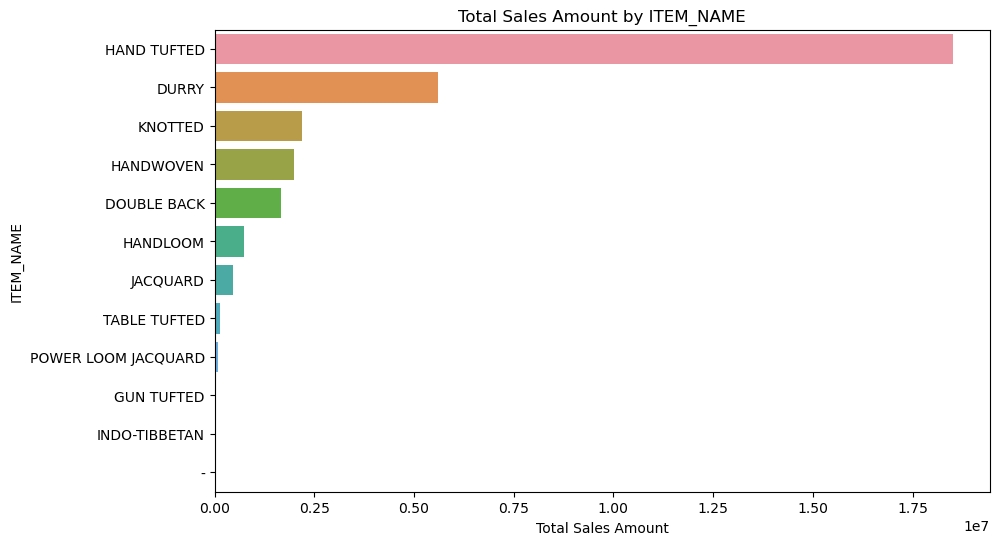

In [113]:
# Aggregate sales data by ITEM_NAME and sum the Amount for each item
item_sales = sales_df.groupby('ITEM_NAME')['Amount'].sum().sort_values(ascending=False).reset_index()

# Plotting the total sales amount for each ITEM_NAME
plt.figure(figsize=(10, 6))
sns.barplot(x='Amount', y='ITEM_NAME', data=item_sales)
plt.title('Total Sales Amount by ITEM_NAME')
plt.xlabel('Total Sales Amount')
plt.ylabel('ITEM_NAME')
plt.show()

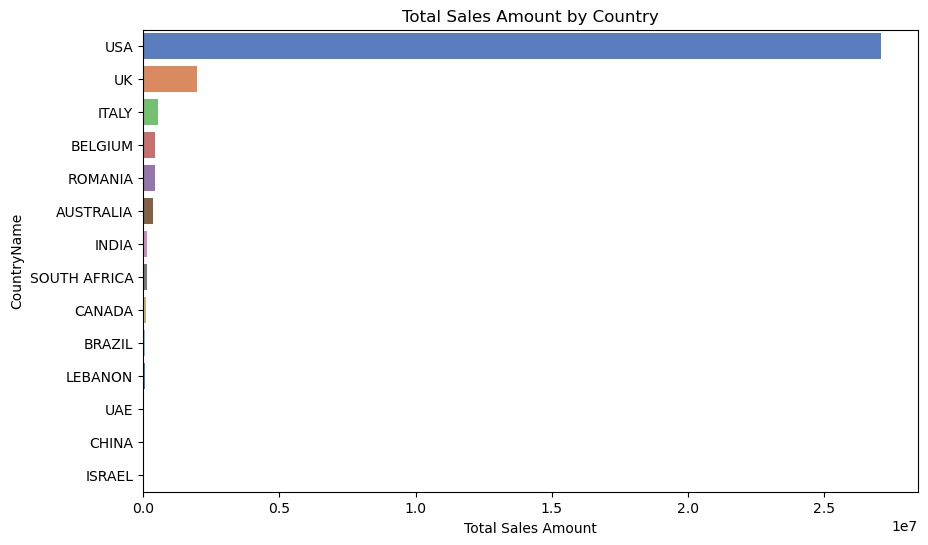

In [114]:
# Aggregate sales data by CountryName and sum the Amount for each country
country_sales = sales_df.groupby('CountryName')['Amount'].sum().sort_values(ascending=False).reset_index()

# Plotting the total sales amount for each CountryName
plt.figure(figsize=(10, 6))
sns.barplot(x='Amount', y='CountryName', data=country_sales, palette='muted')
plt.title('Total Sales Amount by Country')
plt.xlabel('Total Sales Amount')
plt.ylabel('CountryName')
plt.show()

## percentage contribution to Sales by each country

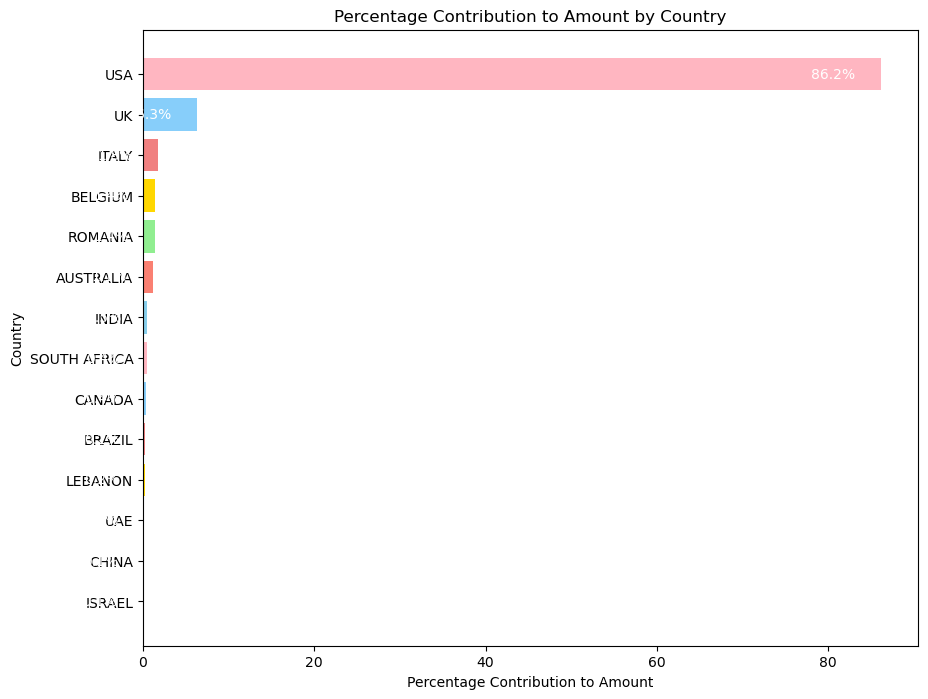

In [137]:
# Calculate the total amount for each country
country_total_amount = sales_df.groupby('CountryName')['Amount'].sum()

# Calculate the percentage contribution of each country to the total amount
percentage_contribution = (country_total_amount / country_total_amount.sum()) * 100

# Custom colors for each country
custom_colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral', 'lightskyblue', 'lightpink']

# Plotting a horizontal bar chart to display the percentage contribution
plt.figure(figsize=(10, 8))
percentage_contribution_sorted = percentage_contribution.sort_values()
bars = plt.barh(percentage_contribution_sorted.index, percentage_contribution_sorted, color=custom_colors)
plt.xlabel('Percentage Contribution to Amount')
plt.ylabel('Country')
plt.title('Percentage Contribution to Amount by Country')

# Adding labels to the bars
for bar, label in zip(bars, percentage_contribution_sorted.index):
    plt.text(bar.get_width() - 3, bar.get_y() + bar.get_height() / 2, f'{percentage_contribution_sorted[label]:.1f}%', 
             va='center', ha='right', color='white')

plt.show()


## Till now, we have identified that USA is giving the maximum number of orders and their cumulative amount is also the largest, now lets see which country is giving the order with maximum items on an average, This will give us the information about which country places a big order amd Champo should never miss this order

/var/folders/l_/8lxk3vrn6qj8n2kpd8fdyd4r0000gn/T/ipykernel_20716/2472865882.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dataForPlot.index, rotation=90)


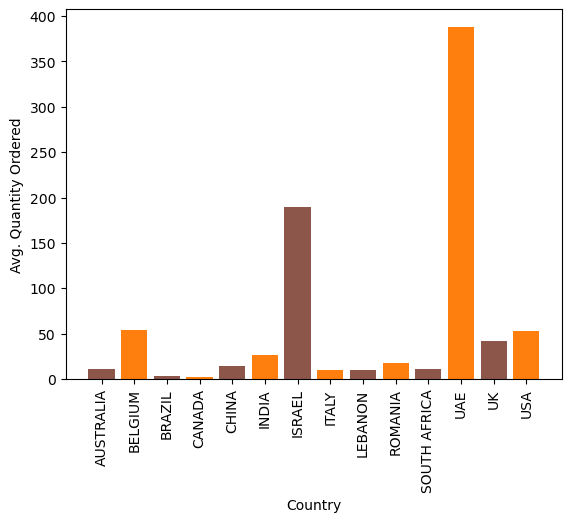

In [115]:
#bar chart of average quantity ordered per country
dataForPlot = sales_df.groupby('CountryName').mean().QtyRequired
fig, ax = plt.subplots()
ax.bar(dataForPlot.index, dataForPlot, color=['C5', 'C1'])
ax.set_xticklabels(dataForPlot.index, rotation=90)
ax.set_xlabel('Country')
ax.set_ylabel('Avg. Quantity Ordered')
plt.show()

## so, it is clear the average order quantity is highest for UAE, like whenever they place an order, it will have the maximum items as compared to the orders by oter country

## Some Extra analysis to see which carpet type is giving the highest revenue on an average  <li>Answer: we found that it was not most selling - HAND TUFTED but rather TABLE TUFTED this may be because it is costly because it was not something which is geting ordered the most

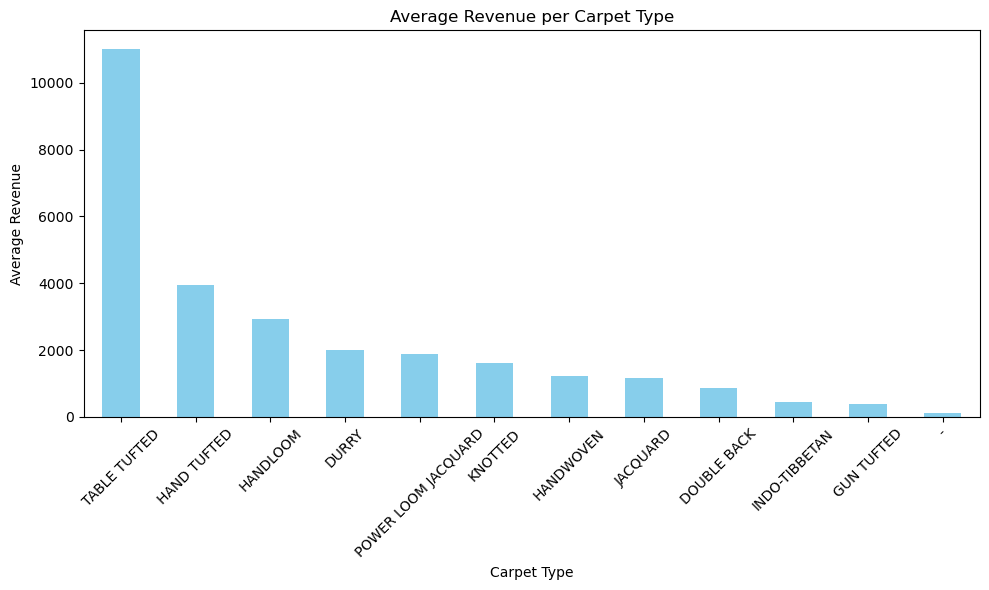

In [117]:
# Calculate average revenue per carpet type
avg_revenue_per_carpet = sales_df.groupby('ITEM_NAME')['Amount'].mean().sort_values(ascending=False)

# Plotting a bar chart for average revenue per carpet type
plt.figure(figsize=(10, 6))
avg_revenue_per_carpet.plot(kind='bar', color='skyblue')
plt.xlabel('Carpet Type')
plt.ylabel('Average Revenue')
plt.title('Average Revenue per Carpet Type')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


## Since USA is the biggest customer, we are digging deep to know their taste more, so that Champo can have that inventory ready. We are finding which item USA orders the most and which Shape they are a fan of!

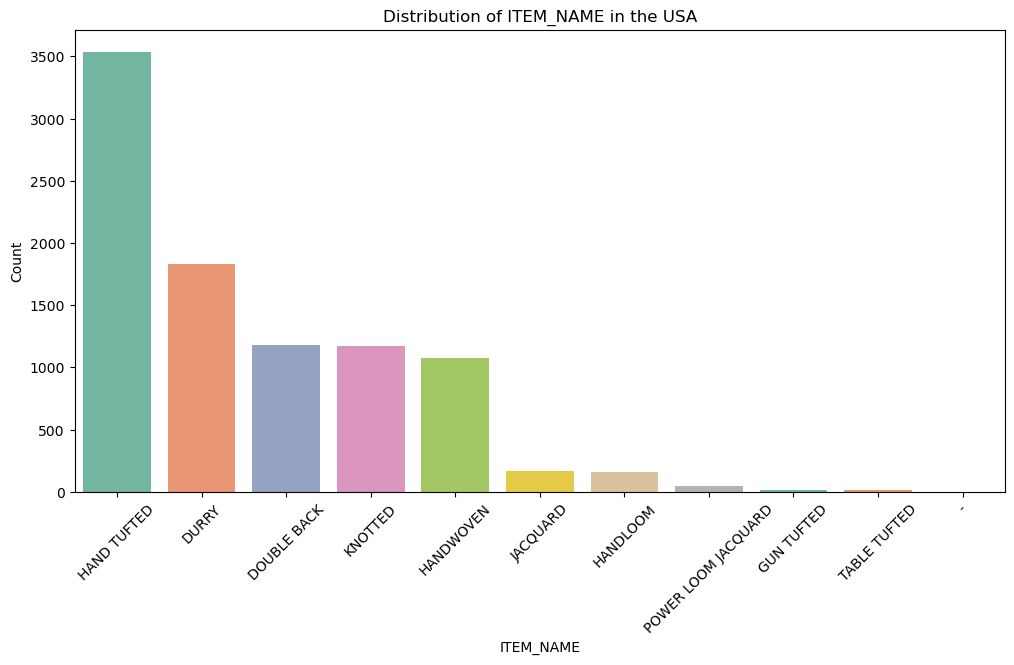

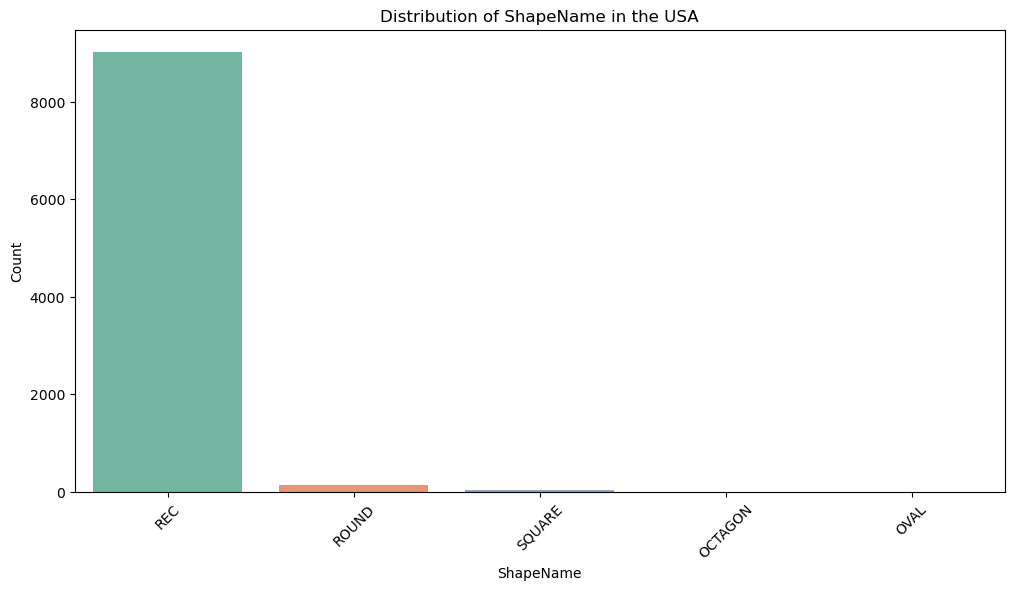

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of attributes to analyze
attributes = ['ITEM_NAME', 'ShapeName']

# Filter data for USA
sales_df_usa = sales_df[sales_df['CountryName'] == 'USA']

# Plotting count plots for each attribute in the USA with sorted bars in descending order
for attribute in attributes:
    plt.figure(figsize=(12, 6))
    order = sales_df_usa[attribute].value_counts().index  # Get value counts and sort index
    sns.countplot(x=attribute, data=sales_df_usa, order=order, palette='Set2')
    plt.title(f'Distribution of {attribute} in the USA')
    plt.xlabel(attribute)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


## Identifying the top 10 customers by their codes who are giving maximum sales

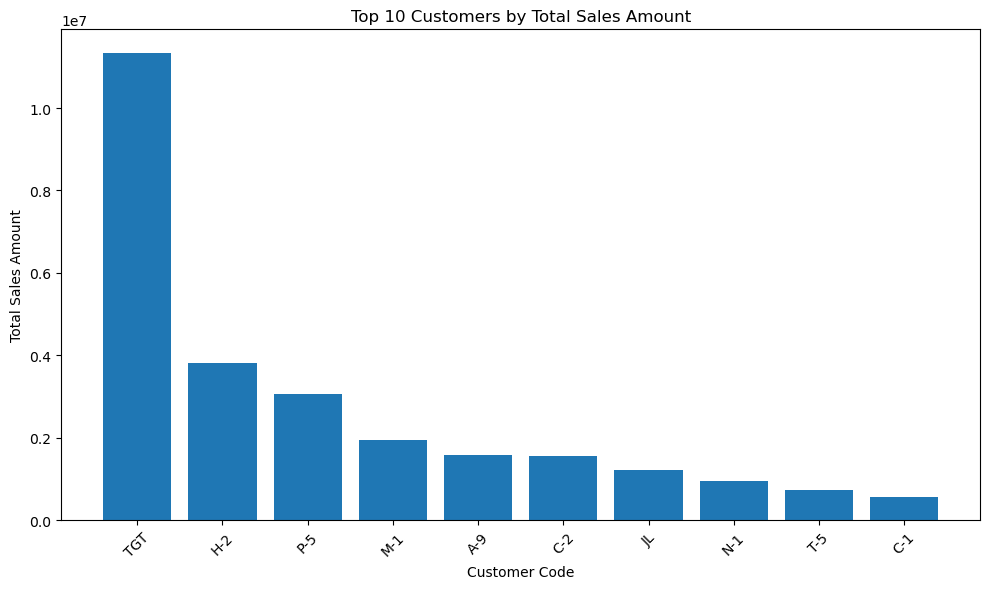

In [119]:
# Group the data by customer code and calculate total sales amount
sales_data = sales_df.groupby('CustomerCode')['Amount'].sum().reset_index()

# Sort the data by total sales amount in descending order
sales_data = sales_data.sort_values('Amount', ascending=False)

# Select the top 10 customers based on total sales amount
top_10_customers = sales_data.head(10)

# Create the bar chart for top 10 customers
fig, ax = plt.subplots(figsize=(10,6))  # Adjust the figure size as needed
plt.bar(top_10_customers['CustomerCode'], top_10_customers['Amount'])
plt.title('Top 10 Customers by Total Sales Amount')
plt.xlabel('Customer Code')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()  # Adjust layout to prevent cropping of labels
plt.show()


## Now, identifying top  customers in top 5 countries. So that once a geograpy is targeted , those customers can be targeted too, and a high amount of sale can be pulled from each top 5 country

In [120]:
# Calculate total sales amount for each customer in each country
customer_country_sales = sales_df.groupby(['CountryName', 'CustomerCode'])['Amount'].sum().reset_index()

# Identify the top 5 countries based on total sales amount
top_5_countries = customer_country_sales.groupby('CountryName')['Amount'].sum().nlargest(5).index.tolist()

# Identify top 5 customers in each of the top 5 countries
top_5_customers = {}
for country in top_5_countries:
    top_customers_country = customer_country_sales[customer_country_sales['CountryName'] == country]
    top_customers = top_customers_country.nlargest(5, 'Amount')
    top_5_customers[country] = top_customers

# Displaying the top 5 customers in the top 5 countries
for country, top_customers in top_5_customers.items():
    print(f"Top 5 customers in {country}:")
    print(top_customers)
    print("-----------------------")


Top 5 customers in USA:
   CountryName CustomerCode     Amount
43         USA          TGT  1.134e+07
31         USA          H-2  3.805e+06
38         USA          P-5  3.067e+06
34         USA          M-1  1.960e+06
22         USA          A-9  1.592e+06
-----------------------
Top 5 customers in UK:
   CountryName CustomerCode     Amount
18          UK           JL  1.232e+06
19          UK          T-5  7.338e+05
-----------------------
Top 5 customers in ITALY:
   CountryName CustomerCode      Amount
12       ITALY          T-2  563098.848
-----------------------
Top 5 customers in BELGIUM:
  CountryName CustomerCode      Amount
3     BELGIUM           PD  404528.945
2     BELGIUM          L-2   21503.495
4     BELGIUM          T-9     758.970
-----------------------
Top 5 customers in ROMANIA:
   CountryName CustomerCode      Amount
14     ROMANIA          I-2  426626.048
-----------------------


Segment Champo's customers

## Question 2 : Clustering of Customer data, which is Data for Clustering sheet of the excel

In [121]:
customer_df = pd.read_excel('IMB881-XLS-ENG.xlsx', sheet_name='Data for Clustering')

In [122]:
customer_df.head()

,Row Labels,Sum of QtyRequired,Sum of TotalArea,Sum of Amount,DURRY,HANDLOOM,DOUBLE BACK,JACQUARD,HAND TUFTED,HAND WOVEN,KNOTTED,GUN TUFTED,Powerloom Jacquard,INDO TEBETAN
0,A-11,2466,139.590,1.854e+05,1021,1445,0,0,0,0,0,0,0,0
1,A-6,131,2086.000,6.247e+03,0,0,25,106,0,0,0,0,0,0
2,A-9,18923,53625.654,1.592e+06,3585,0,175,714,11716,2116,617,0,0,0
3,B-2,624,202.899,1.481e+04,581,0,0,2,0,41,0,0,0,0
4,B-3,464,8451.562,5.863e+04,0,0,459,5,0,0,0,0,0,0


In [123]:
customer_df.shape

(45, 14)

In [124]:
customer_df.columns

Index(['Row Labels', 'Sum of QtyRequired', 'Sum of TotalArea', 'Sum of Amount',
       'DURRY', 'HANDLOOM', 'DOUBLE BACK', 'JACQUARD', 'HAND TUFTED',
       'HAND WOVEN', 'KNOTTED', 'GUN TUFTED', 'Powerloom Jacquard',
       'INDO TEBETAN'],
      dtype='object')

In [125]:
customer_df.describe()

,Sum of QtyRequired,Sum of TotalArea,Sum of Amount,DURRY,HANDLOOM,DOUBLE BACK,JACQUARD,HAND TUFTED,HAND WOVEN,KNOTTED,GUN TUFTED,Powerloom Jacquard,INDO TEBETAN
count,45.000,45.000,4.500e+01,45.000,45.000,45.000,45.000,45.000,45.000,45.000,45.000,45.000,45.000
mean,12977.556,13056.590,6.982e+05,7103.000,185.533,407.911,89.422,3650.844,867.689,365.756,8.133,216.733,0.711
std,30550.742,34474.177,1.809e+06,22160.531,607.655,1166.855,175.797,9917.428,2418.324,1503.045,34.110,1453.891,3.442
min,2.000,1.350,3.289e+02,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,565.000,376.769,3.970e+04,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1566.000,2120.000,1.168e+05,289.000,0.000,0.000,0.000,510.000,0.000,0.000,0.000,0.000,0.000
75%,11146.000,8451.562,4.266e+05,1560.000,0.000,175.000,72.000,3544.000,269.000,18.000,0.000,0.000,0.000
max,183206.000,209725.222,1.134e+07,139618.000,3673.000,5439.000,714.000,60685.000,14314.000,9502.000,195.000,9753.000,20.000


In [126]:
customer_df.dtypes

Row Labels             object
Sum of QtyRequired      int64
Sum of TotalArea      float64
Sum of Amount         float64
DURRY                   int64
HANDLOOM                int64
DOUBLE BACK             int64
JACQUARD                int64
HAND TUFTED             int64
HAND WOVEN              int64
KNOTTED                 int64
GUN TUFTED              int64
Powerloom Jacquard      int64
INDO TEBETAN            int64
dtype: object

In [127]:
#setting Row-label column as index
customer_df.set_index('Row Labels', inplace=True)

# Convert all columns to 'float'. While this step is not required, the conversion of integer data to float will avoid a warning when 
# applying the scale function
customer_df = customer_df.apply(lambda x: x.astype('float64')) #lambda is used for custom functions. 
customer_df.dtypes

Sum of QtyRequired    float64
Sum of TotalArea      float64
Sum of Amount         float64
DURRY                 float64
HANDLOOM              float64
DOUBLE BACK           float64
JACQUARD              float64
HAND TUFTED           float64
HAND WOVEN            float64
KNOTTED               float64
GUN TUFTED            float64
Powerloom Jacquard    float64
INDO TEBETAN          float64
dtype: object

In [128]:
customer_df.head()

,Sum of QtyRequired,Sum of TotalArea,Sum of Amount,DURRY,HANDLOOM,DOUBLE BACK,JACQUARD,HAND TUFTED,HAND WOVEN,KNOTTED,GUN TUFTED,Powerloom Jacquard,INDO TEBETAN
Row Labels,,,,,,,,,,,,,
A-11,2466.0,139.590,1.854e+05,1021.0,1445.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A-6,131.0,2086.000,6.247e+03,0.0,0.0,25.0,106.0,0.0,0.0,0.0,0.0,0.0,0.0
A-9,18923.0,53625.654,1.592e+06,3585.0,0.0,175.0,714.0,11716.0,2116.0,617.0,0.0,0.0,0.0
B-2,624.0,202.899,1.481e+04,581.0,0.0,0.0,2.0,0.0,41.0,0.0,0.0,0.0,0.0
B-3,464.0,8451.562,5.863e+04,0.0,0.0,459.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0


## First, trying euclidean distance method on the normalized dataset, and will will experiment with different linkage method. 

In [129]:
from sklearn.preprocessing import StandardScaler

# Normalizing the customer_df using StandardScaler()
scaler = StandardScaler()
customer_df_normalized = scaler.fit_transform(customer_df)

In [130]:
from scipy.spatial.distance import pdist, squareform

# Calculating Euclidean distance
#plugging in the normalised dataset to calculate euclidean distance between points
d_euclidean = pdist(customer_df_normalized, metric='euclidean') 
distance_matrix_euclidean = squareform(d_euclidean)


/var/folders/l_/8lxk3vrn6qj8n2kpd8fdyd4r0000gn/T/ipykernel_20716/3893757275.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix_euclidean, method=method, metric='euclidean')


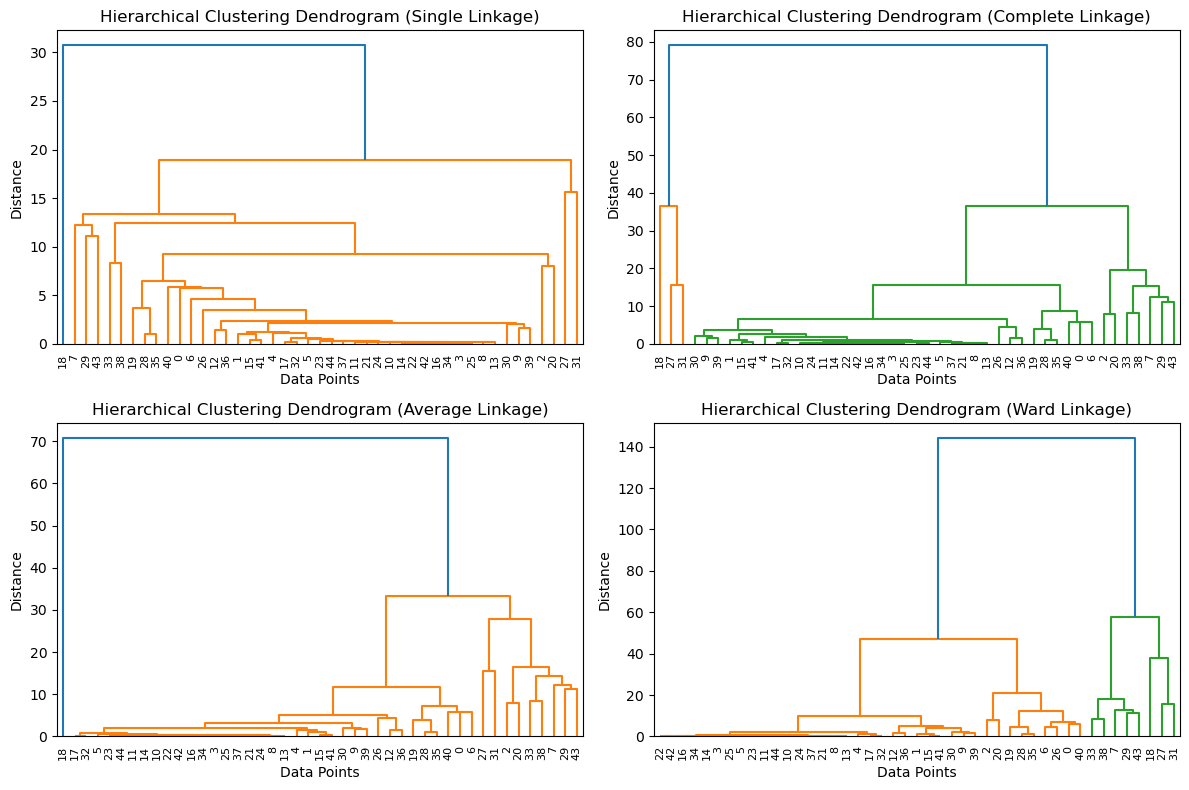

In [131]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Linkage methods to experiment with
linkage_methods = ['single', 'complete', 'average', 'ward']

# Plotting dendrograms for different linkage methods
plt.figure(figsize=(12, 8))

for i, method in enumerate(linkage_methods, 1):
    plt.subplot(2, 2, i)
    # plugging in the distance_matrix_euclidean in the linkage funtion
    linkage_matrix = linkage(distance_matrix_euclidean, method=method, metric='euclidean') 
    dendrogram(linkage_matrix)
    plt.title(f'Hierarchical Clustering Dendrogram ({method.capitalize()} Linkage)')
    plt.xlabel('Data Points')
    plt.ylabel('Distance')

plt.tight_layout()
plt.show()


## seeing the above dendograms makes us to choose maximum 3 clusters, Ideally no bar in the dendogram should not have a single point in it, as it would mean that only that point belongs to that cluster. But here, in all the cases there is at least one cluster with a single datapoint

## So, we have opted 3 clusters as maximum limit and now assigning data labels to these three clusters using various linkage method, as asked in the question

In [132]:
from scipy.cluster.hierarchy import linkage, fcluster

# Define linkage methods to experiment with
linkage_methods = ['single', 'complete', 'average', 'ward']

# Dictionary to store cluster memberships for each method
cluster_memberships = {}

# Loop through each linkage method
for method in linkage_methods:
    # Compute linkage matrix for the current method
    linkage_matrix = linkage(customer_df_normalized, method=method)
    
    # Assign cluster labels using fcluster
    num_clusters = 3 
    cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    
    # Create a Pandas Series with cluster labels and row indices
    cluster_membership = pd.Series(cluster_labels, index=customer_df.index)
    
    # Store cluster membership in the dictionary
    cluster_memberships[method] = cluster_membership

    # Print indices for each cluster
    print(f"Cluster membership for '{method}' linkage:")
    for key, item in cluster_membership.groupby(cluster_membership):
        print(f'Cluster {key}: {", ".join(item.index)}')
    print("----------------------")


Cluster membership for 'single' linkage:
Cluster 1: A-11, A-6, A-9, B-2, B-3, B-4, C-1, C-2, C-3, CC, CTS, DR, E-2, F-1, F-6, G-1, G-4, H-1, I-2, JL, K-2, K-3, L-2, L-3, L-4, L-5, M-2, N-1, P-4, P-5, PC, PD, R-4, RC, S-2, S-3, T-2, T-4, T-5, T-6, T-9, TGT, V-1
Cluster 2: M-1
Cluster 3: H-2
----------------------
Cluster membership for 'complete' linkage:
Cluster 1: M-1, P-5
Cluster 2: A-11, A-6, A-9, B-2, B-3, B-4, C-1, C-2, C-3, CC, CTS, DR, E-2, F-1, F-6, G-1, G-4, H-1, I-2, JL, K-2, K-3, L-2, L-3, L-4, L-5, M-2, N-1, P-4, PC, PD, R-4, RC, S-2, S-3, T-2, T-4, T-5, T-6, T-9, TGT, V-1
Cluster 3: H-2
----------------------
Cluster membership for 'average' linkage:
Cluster 1: A-11, A-6, A-9, B-2, B-3, B-4, C-1, C-2, C-3, CC, CTS, DR, E-2, F-1, F-6, G-1, G-4, H-1, I-2, JL, K-2, K-3, L-2, L-3, L-4, L-5, M-2, N-1, P-4, PC, PD, R-4, RC, S-2, S-3, T-2, T-4, T-5, T-6, T-9, TGT, V-1
Cluster 2: M-1, P-5
Cluster 3: H-2
----------------------
Cluster membership for 'ward' linkage:
Cluster 1: M-1, 

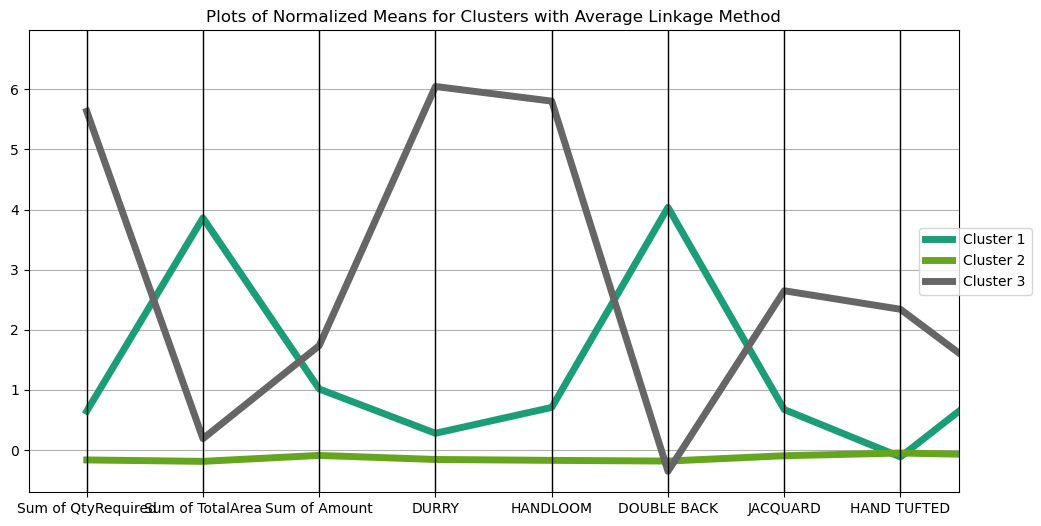

In [133]:
# Create data frame with means of each normalized input variable (measurement) for each cluster 

customer_df_normalized = pd.DataFrame(customer_df_normalized, columns=customer_df.columns)
clust_mean_norm = customer_df_normalized.groupby(cluster_labels).mean()
# Add cluster titles (Cluster 1, Cluster 2, ...) to cluster_mean data frame with means and precision of 3 decimals. 
clust_mean_norm['Cluster'] = ['Cluster {}'.format(i) for i in clust_mean_norm.index]
pd.set_option('display.precision', 3)

# Display the data frame with normalized mean values and cluster titles.
clust_mean_norm

# Display profile plots of normalized means of each input variable for each cluster
plt.figure(figsize=(12,6))
fig.subplots_adjust(right=3)
ax = parallel_coordinates(clust_mean_norm, class_column='Cluster', 
                          colormap='Dark2', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,7.5)
plt.title('Plots of Normalized Means for Clusters with Average Linkage Method')
plt.show()

Cluster 2: Customers in this group prefer buying fewer carpets, and they tend to choose smaller-sized carpets with less emphasis on specific features like durry, handloom, double back, jacquard, and hand-tufted styles.

Cluster 1: Customers in this group typically buy a moderate quantity of carpets, opting for larger-sized ones. They show a moderate interest in durry and handloom styles, a high preference for double back, and lower interest in jacquard and hand-tufted styles.

Cluster 3: There's only one customer in this group who buys a high quantity of carpets. However, they prefer slightly smaller carpets compared to Cluster 2. These carpets are priced higher, and this customer shows a strong preference for durry and handloom styles, very little interest in double back, and a moderate interest in jacquard and hand-tufted styles.

In [134]:
## end of the code